In [1]:
import defeatbeta_api
from defeatbeta_api.data.ticker import Ticker
import numpy as np
import pandas as pd
import timesfm

import torch


______      __           _    ______      _        
|  _  \    / _|         | |   | ___ \    | |       
| | | |___| |_ ___  __ _| |_  | |_/ / ___| |_ __ _ 
| | | / _ \  _/ _ \/ _` | __| | ___ \/ _ \ __/ _` |
| |/ /  __/ ||  __/ (_| | |_  | |_/ /  __/ || (_| |
|___/ \___|_| \___|\__,_|\__| \____/ \___|\__\__,_|
📈:: Data Update Time ::	2025-10-31 ::
📈:: Software Version ::	0.0.6      ::


/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch", torch_compile=True)




Downloaded.
Compiling model...


In [23]:
model.compile(
    timesfm.ForecastConfig(
        max_context=64,          # model context limit
        max_horizon=20,           # supports up to 256 steps
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)


In [24]:
model

In [3]:
ticker = Ticker('TSLA')
ticker.price()

,symbol,report_date,open,close,high,low,volume
0,TSLA,2010-06-29,1.27,1.59,1.67,1.17,281494500
1,TSLA,2010-06-30,1.72,1.59,2.03,1.55,257806500
2,TSLA,2010-07-01,1.67,1.46,1.73,1.35,123282000
3,TSLA,2010-07-02,1.53,1.28,1.54,1.25,77097000
4,TSLA,2010-07-06,1.33,1.07,1.33,1.06,103003500
...,...,...,...,...,...,...,...
3856,TSLA,2025-10-27,439.98,452.42,460.16,438.69,105867500
3857,TSLA,2025-10-28,454.78,460.55,467.00,451.60,80185700
3858,TSLA,2025-10-29,462.50,461.51,465.70,452.65,67983500
3859,TSLA,2025-10-30,451.05,440.10,455.06,439.61,72447900


In [10]:


def load_close_series(symbol: str) -> pd.Series:
    """
    Returns a pandas Series of 'close' indexed by datetime.
    """
    df = Ticker(symbol).price()                       # has report_date, open/close/high/low/volume
    df = df.sort_values("report_date")                # chronological
    s = pd.to_numeric(df["close"], errors="coerce")   # ensure numeric
    s.index = pd.to_datetime(df["report_date"])       # datetime index
    s.name = symbol
    return s

close_aapl = load_close_series("NVDA")
close_aapl.tail()

report_date
2025-10-27    191.49
2025-10-28    201.03
2025-10-29    207.04
2025-10-30    202.89
2025-10-31    202.49
Name: NVDA, dtype: float64

In [13]:
def load_ohlcv(symbol: str) -> pd.DataFrame:
    """
    Returns a DataFrame indexed by datetime with columns: open, high, low, close, volume.
    """
    df = Ticker(symbol).price().sort_values("report_date")
    out = df[["report_date", "open", "high", "low", "close", "volume"]].copy()
    out["report_date"] = pd.to_datetime(out["report_date"])
    out = out.set_index("report_date")
    out.columns = pd.Index(out.columns, name="field")
    return out

ohlcv_nvda = load_ohlcv("NVDA")
ohlcv_nvda.tail()

field,open,high,low,close,volume
report_date,,,,,
2025-10-27,189.99,192.00,188.43,191.49,153452700
2025-10-28,193.05,203.15,191.91,201.03,297986200
2025-10-29,207.98,212.19,204.78,207.04,308829600
2025-10-30,205.15,206.16,201.41,202.89,178864400
2025-10-31,206.45,207.97,202.07,202.49,179485000


In [46]:
ohlcv_nvda.to_csv("ohlcv_nvda.csv", index=True)

In [41]:
ohlcv_nvda.describe()

field,open,high,low,close,volume
count,6737.000000,6737.000000,6737.000000,6737.000000,6.737000e+03
mean,12.551036,12.767624,12.314042,12.552853,5.890003e+08
std,33.136161,33.662391,32.537512,33.129745,4.295794e+08
min,0.030000,0.040000,0.030000,0.030000,1.968000e+07
25%,0.280000,0.290000,0.280000,0.290000,3.243320e+08
50%,0.480000,0.490000,0.470000,0.480000,4.918920e+08
75%,5.390000,5.460000,5.280000,5.370000,7.210440e+08
max,207.980000,212.190000,204.780000,207.040000,9.230856e+09


In [43]:
summary = pd.DataFrame({
    "mean": ohlcv_nvda.mean(),
    "std": ohlcv_nvda.std(),
    "min": ohlcv_nvda.min(),
    "max": ohlcv_nvda.max(),
    "median": ohlcv_nvda.median(),
    "skew": ohlcv_nvda.skew()

})

summary

,mean,std,min,max,median,skew,kurtosis
field,,,,,,,
open,1.255104e+01,3.313616e+01,0.03,2.079800e+02,4.800000e-01,3.481223,11.750549
high,1.276762e+01,3.366239e+01,0.04,2.121900e+02,4.900000e-01,3.469608,11.642925
low,1.231404e+01,3.253751e+01,0.03,2.047800e+02,4.700000e-01,3.492058,11.858928
close,1.255285e+01,3.312974e+01,0.03,2.070400e+02,4.800000e-01,3.479671,11.739232
volume,5.890003e+08,4.295794e+08,19680000.00,9.230856e+09,4.918920e+08,3.833789,37.871542


In [14]:
def time_split(df: pd.DataFrame, train_end: str, val_end: str):
    """
    Split by calendar cutoffs (inclusive train_end, inclusive val_end).
    """
    train = df.loc[:train_end]
    val   = df.loc[train_end:val_end].iloc[1:]  # avoid duplicate boundary row
    test  = df.loc[val_end:].iloc[1:]
    return train, val, test


train, val, test = time_split(ohlcv_nvda, train_end="2023-12-31", val_end="2024-12-31")

In [44]:
train.head(-5)

field,open,high,low,close,volume
report_date,,,,,
1999-01-22,0.04,0.05,0.04,0.04,2714688000
1999-01-25,0.04,0.05,0.04,0.05,510480000
1999-01-26,0.05,0.05,0.04,0.04,343200000
1999-01-27,0.04,0.04,0.04,0.04,244368000
1999-01-28,0.04,0.04,0.04,0.04,227520000
...,...,...,...,...,...
2023-12-15,48.19,49.40,48.12,48.89,479948000
2023-12-18,49.40,50.43,49.15,50.08,412587000
2023-12-19,49.42,49.70,48.90,49.60,464444000


In [18]:
def build_ohlcv_windows(df, context: int = 64, horizon: int = 10, target_col: str = "close"):
    """
    df: DataFrame indexed by datetime with columns [open, high, low, close, volume]
    context: number of past days used to predict
    horizon: number of future days to predict
    target_col: which column to forecast (e.g., "close")
    
    returns:
        X: (num_windows, context, num_features)
        y: (num_windows, horizon)
    """
    values = df.values.astype(np.float32)        # shape (T, num_features)
    target = df[target_col].values.astype(np.float32)

    X_list, y_list = [], []
    T = len(df)

    for start in range(T - context - horizon + 1):
        end = start + context
        X_list.append(values[start:end])               # shape (context, features)
        y_list.append(target[end:end + horizon])       # shape (horizon,)

    X = np.stack(X_list) if X_list else np.empty((0, context, df.shape[1]), dtype=np.float32)
    y = np.stack(y_list) if y_list else np.empty((0, horizon), dtype=np.float32)

    return X, y



In [19]:
# Example usage:
# df = your OHLCV DataFrame indexed by report_date
X, y = build_ohlcv_windows(ohlcv_nvda, context=64, horizon=20)
X.shape, y.shape

((6654, 64, 5), (6654, 20))

In [ ]:
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,          # model context limit
        max_horizon=256,           # supports up to 256 steps
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)


In [31]:
def extract_close_from_ohlcv(df: pd.DataFrame) -> np.ndarray:
    """
    From an OHLCV DataFrame (datetime index, columns open/high/low/close/volume),
    return the 'close' column as float32 1D array.
    """
    close = pd.to_numeric(df["close"], errors="coerce").dropna().values.astype(np.float32)
    return close

In [34]:
series_window = extract_close_from_ohlcv(ohlcv_nvda)
len(series_window), series_window[-5:]

(6737, array([191.49, 201.03, 207.04, 202.89, 202.49], dtype=float32))

In [36]:
# Load TimesFM 2.5 (PyTorch) and keep config in CFG
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

CFG = timesfm.ForecastConfig(
    max_context=1024,
    max_horizon=256,
    normalize_inputs=True,
    use_continuous_quantile_head=True,
    force_flip_invariance=True,
    infer_is_positive=True,
    fix_quantile_crossing=True,
)

model.compile(CFG)

model  # sanity check

Downloaded.


In [37]:
def timesfm_forecast(window_1d: np.ndarray, horizon: int = 20) -> pd.DataFrame:
    # Respect model limits
    context_len = CFG.max_context
    horizon = min(horizon, CFG.max_horizon)

    # Trim to context and run
    ctx = window_1d[-context_len:].astype(np.float32)

    point_fcst, quant_fcst = model.forecast(
        horizon=horizon,
        inputs=[ctx],
    )

    mean = point_fcst[0]            # (horizon,)
    p10  = quant_fcst[0, :, 1]      # 10th percentile
    p90  = quant_fcst[0, :, 9]      # 90th percentile

    return pd.DataFrame({
        "step": np.arange(1, horizon + 1, dtype=int),
        "mean": mean,
        "p10":  p10,
        "p90":  p90,
    })

In [49]:
H = 20
pred_df = timesfm_forecast(series_window, horizon=H)
pred_df.head()

,step,mean,p10,p90
0,1,49.620369,47.830849,51.166229
1,2,49.460976,47.373795,51.550392
2,3,49.360023,46.779102,51.802452
3,4,49.540386,46.905525,52.226528
4,5,49.212147,46.139656,52.252350


In [52]:
pred_df.describe()

,step,mean,p10,p90
count,20.00000,20.000000,20.000000,20.000000
mean,10.50000,49.456490,45.244549,53.421082
std,5.91608,0.140488,1.261698,1.238874
min,1.00000,49.212147,43.041206,51.166229
25%,5.75000,49.338339,44.437286,52.458158
50%,10.50000,49.480728,44.926630,53.578184
75%,15.25000,49.564151,45.831155,54.420318
max,20.00000,49.681107,47.830849,55.252449


In [49]:
H = 20
pred_df = timesfm_forecast(series_window, horizon=H)
pred_df.head()

,step,mean,p10,p90
0,1,49.620369,47.830849,51.166229
1,2,49.460976,47.373795,51.550392
2,3,49.360023,46.779102,51.802452
3,4,49.540386,46.905525,52.226528
4,5,49.212147,46.139656,52.252350


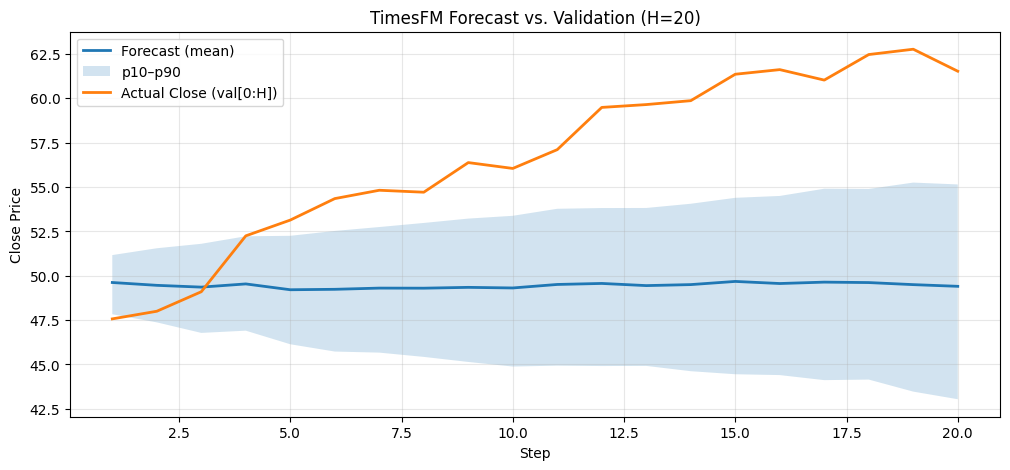

In [68]:

# H = horizon we want to validate
H = min(20, len(pred_df))  # safety if pred_df shorter

# Grab validation close series (supports val as Series or DataFrame)
val_close = val if isinstance(val, pd.Series) else val["close"]

# First H validation points
y_true = val_close.iloc[:H].to_numpy()

# X-axis: dates if pred_df has a DatetimeIndex, else integer steps
if isinstance(pred_df.index, pd.DatetimeIndex):
    x = pred_df.index[:H]
else:
    x = np.arange(1, H + 1)

# Slice forecast to H
y_pred_mean = pred_df["mean"].iloc[:H].to_numpy()
y_pred_p10  = pred_df["p10"].iloc[:H].to_numpy()
y_pred_p90  = pred_df["p90"].iloc[:H].to_numpy()

plt.figure(figsize=(12, 5))
plt.plot(x, y_pred_mean, label="Forecast (mean)", linewidth=2)
plt.fill_between(x, y_pred_p10, y_pred_p90, alpha=0.2, label="p10–p90")

# Plot the true validation closes on the same x-range
plt.plot(x, y_true, label="Actual Close (val[0:H])", linewidth=2)

plt.title(f"TimesFM Forecast vs. Validation (H={H})")
plt.xlabel("Date" if isinstance(pred_df.index, pd.DatetimeIndex) else "Step")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("forecast_vs_val.png", dpi=300, bbox_inches="tight")
plt.show()